In [ ]:
import pandas as pd
import geopandas as gpd
import ast
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
import glob
import numpy as np
import matplotlib.ticker as mticker



In [ ]:
property_type = 'Apartments' # 'Houses', 'Apartments', 'Offices'
year = 2025
quarter = 1  # Change this to the desired quarter (1, 2, 3, or 4)


In [3]:

# Get all CSV files matching the pattern
csv_files = glob.glob(f'../../../data/{property_type}/listings_data_m2_medellin*.csv')


# Read and concatenate all CSV files into a single DataFrame
df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

In [4]:
# Convert 'Extraction Date' to datetime if not already
df['Extraction Date'] = pd.to_datetime(df['Extraction Date'])



start_month = 3 * (quarter - 1) + 1
end_month = start_month + 2
mask = (
    (df['Extraction Date'].dt.year == year) &
    (df['Extraction Date'].dt.month >= start_month) &
    (df['Extraction Date'].dt.month <= end_month)
)
df =  df[mask]

# df

In [5]:
df.drop_duplicates(subset='propertyId', inplace=True)

In [6]:

# Extract longitude and latitude from the 'coordinates' column
df['coordinates'] = df['coordinates'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['lon'] = df['coordinates'].apply(lambda x: x.get('lon') if isinstance(x, dict) else None)
df['lat'] = df['coordinates'].apply(lambda x: x.get('lat') if isinstance(x, dict) else None)

# Drop rows with missing coordinates
df = df[(df['lon'] != 0.0) & (df['lat'] != 0.0)]
df_map = df.dropna(subset=['lon', 'lat'])



In [7]:
# Load the shapefile
gdf = gpd.read_file('shp_comunas_y_corregimientos_/comunas_y_corregimientos_.shp')
gdf = gdf.drop(columns=['fecha_actu'])
gdf = gdf[~gdf['nombre'].isin([
    'Corregimiento de San Sebastián de Palmitas',
    'Corregimiento de San Cristóbal',
    'Corregimiento de Altavista',
    'Corregimiento de Santa Elena',
    'Corregimiento de San Antonio de Prado',
    'None'
])]

gdf = gdf[gdf['nombre'].notna()]

In [8]:

# Ensure gdf is in the same CRS as the coordinates (EPSG:4326)
gdf_4326 = gdf.to_crs(epsg=4326)

# Create geometry column in df_map
df_map['geometry'] = df_map.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# Convert df_map to GeoDataFrame
gdf_points = gpd.GeoDataFrame(df_map, geometry='geometry', crs='EPSG:4326')

# Spatial join to get neighbourhood names
gdf_points = gpd.sjoin(gdf_points, gdf_4326[['nombre', 'geometry']], how='left', predicate='within')

# Add the neighbourhood name from gdf as a new column
df_map['neighbourhood_from_shape'] = gdf_points['nombre']

/tmp/ipykernel_550553/1551281998.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_map['geometry'] = df_map.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
/tmp/ipykernel_550553/1551281998.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_map['neighbourhood_from_shape'] = gdf_points['nombre']


In [9]:
# Calculate average and median salePrice for each neighbourhood in df_map
avg_price_by_neigh = df_map.groupby('neighbourhood_from_shape')['salePrice'].mean()
median_price_by_neigh = df_map.groupby('neighbourhood_from_shape')['salePrice'].median()

# Calculate the Semi-Interquartile Range (SIQR) for each neighbourhood
q1 = df_map.groupby('neighbourhood_from_shape')['salePrice'].quantile(0.25)
q3 = df_map.groupby('neighbourhood_from_shape')['salePrice'].quantile(0.75)
siqr_by_neigh = (q3 - q1) / 2

# Map SIQR to the gdf_4326 GeoDataFrame
gdf_4326['siqr'] = gdf_4326['nombre'].map(siqr_by_neigh)


# Calculate the number of properties per neighbourhood
count_by_neigh = df_map.groupby('neighbourhood_from_shape')['salePrice'].count()
gdf_4326['num_properties'] = gdf_4326['nombre'].map(count_by_neigh).fillna(0).astype(int)

# Map the average price to the gdf_4326 GeoDataFrame based on 'nombre'
gdf_4326['avg_price'] = gdf_4326['nombre'].map(avg_price_by_neigh)
gdf_4326['median_price'] = gdf_4326['nombre'].map(median_price_by_neigh)


# If the number of properties is less than 5, make the avg_price equal to nan
gdf_4326.loc[gdf_4326['num_properties'] < 5, 'avg_price'] = np.nan
gdf_4326.loc[gdf_4326['num_properties'] < 5, 'median_price'] = np.nan


# gdf_4326['avg_price'] = gdf_4326['avg_price'].fillna(0)

# gdf_4326

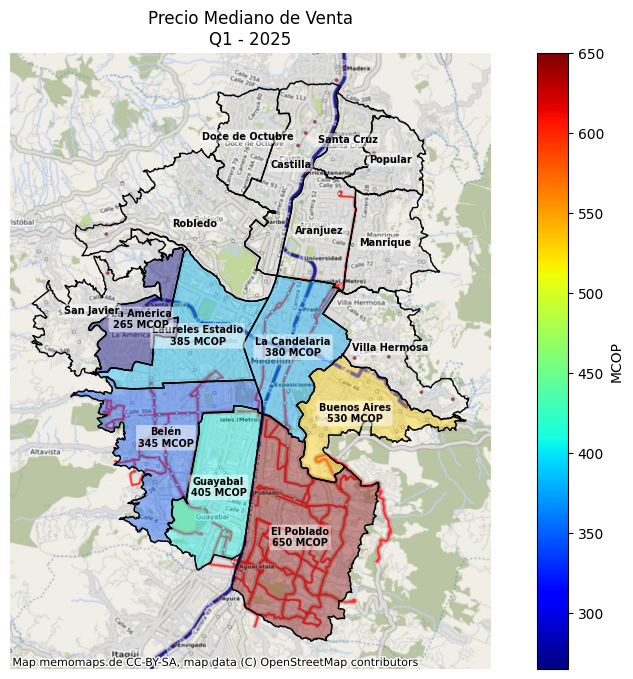

In [10]:
# Set the map provider for the basemap
map_provider = 'OPNVKarte'

# Create the figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Filter neighbourhoods with valid (non-NaN, non-zero) median prices
gdf_4326_valid = gdf_4326[gdf_4326['median_price'].notna() & (gdf_4326['median_price'] != 0)]

# Plot the valid neighbourhoods colored by median price
plot = gdf_4326_valid.plot(
    column='median_price', ax=ax, legend=True, cmap='jet', edgecolor='k', alpha=0.4
)

# Draw the edges of all neighbourhoods (including those without data)
gdf_4326.plot(facecolor='none', ax=ax, edgecolor='k')

# Add the basemap tiles to the plot
source = ctx.providers[map_provider]
ctx.add_basemap(ax, crs=gdf_4326.crs.to_string(), source=source)

# Set the plot title and remove axis
plt.title(f'Precio Mediano de Venta\nQ{quarter} - {year}')
plt.axis('off')

# Format the colorbar to show values in millions of COP
cbar = plot.get_figure().axes[-1]
cbar.set_ylabel('MCOP')
cbar.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}'))

# Annotate each neighbourhood
for idx, row in gdf_4326.iterrows():
    centroid = row['geometry'].centroid
    neighbourhood_name = row['nombre']
    median_price = row['median_price']
    if not np.isnan(median_price) and median_price != 0:
        value = median_price / 1e6
        label = f'{neighbourhood_name}\n{value:,.0f} MCOP'
    else:
        label = f'{neighbourhood_name}'
    ax.annotate(
        label,
        (centroid.x, centroid.y),
        color='black',
        fontsize=7,
        ha='center',
        va='center',
        fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2')
    )

# Display the plot
plt.show()
